<a href="https://colab.research.google.com/github/NandakrishnanR/Kaggle_projects/blob/master/DecisionTree%26randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jsphyg/weather-dataset-rattle-package")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'weather-dataset-rattle-package' dataset.
Path to dataset files: /kaggle/input/weather-dataset-rattle-package


In [51]:
import pandas as pd
raw_df=pd.read_csv(f"/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv")

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [53]:
print(raw_df.isnull().sum())

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64


In [54]:
#Given that 'RainTomorrow' is almost certainly your target variable for a prediction task, it's generally best to remove the rows where 'RainTomorrow' is null. Imputing a categorical target variable can lead to your model learning from artificially generated labels, making your model's evaluation and predictions unreliable. You have 3267 missing values for 'RainTomorrow' out of 145,460 entries, which is about 2.2%. Removing these rows is a reasonable approach to ensure data quality for your target variable.
raw_df.dropna(subset = ['RainTomorrow'], inplace = True)


## Preparing the Data for Training

steps to prepare the dataset for training:

1. Create a train/test/validation split
2. Identify input and target columns
3. Identify numeric and categorical columns
4. Impute (fill) missing numeric values
5. Scale numeric values to the $(0, 1)$ range
6. Encode categorical columns to one-hot vectors

In [55]:
year = pd.to_datetime(raw_df['Date']).dt.year
raw_df['year'] = year
from plotly import express as px
px.histogram(raw_df, x='year', color='RainToday', title='Rain Today by Year')

In [56]:
train_df=raw_df[raw_df['year']<2016]
val_df=raw_df[raw_df['year'] == 2016]
test_df=raw_df[raw_df['year'] > 2016]

In [57]:
input_col=list(raw_df.columns)
input_col.remove('RainTomorrow')
input_col.remove('Date')
input_col.remove('year')
target_col='RainTomorrow'
train_input=train_df[input_col].copy()
train_target=train_df[target_col].copy()
val_input=val_df[input_col].copy()
val_target=val_df[target_col].copy()
test_input=test_df[input_col].copy()
test_target=test_df[target_col].copy()


In [58]:

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pandas as pd



#  Numeric columns
num_cols = train_input.select_dtypes(include=['int64','float64']).columns.tolist()

imputer = SimpleImputer(strategy='mean')
imputer.fit(train_input[num_cols])

train_num = imputer.transform(train_input[num_cols])
val_num   = imputer.transform(val_input[num_cols])
test_num  = imputer.transform(test_input[num_cols])

scaler = MinMaxScaler()
scaler.fit(train_num)

train_num = scaler.transform(train_num)
val_num   = scaler.transform(val_num)
test_num  = scaler.transform(test_num)

train_num_df = pd.DataFrame(train_num, columns=num_cols, index=train_input.index)
val_num_df   = pd.DataFrame(val_num,   columns=num_cols, index=val_input.index)
test_num_df  = pd.DataFrame(test_num,  columns=num_cols, index=test_input.index)

# Categorical columns
cat_cols = train_input.select_dtypes(include=['object','string','category']).columns.tolist()

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(train_input[cat_cols])

enc_cols = ohe.get_feature_names_out().tolist()

train_cat= ohe.transform(train_input[cat_cols])
val_cat = ohe.transform(val_input[cat_cols])
test_cat = ohe.transform(test_input[cat_cols])

train_cat_df = pd.DataFrame(train_cat, columns=enc_cols, index=train_input.index)
val_cat_df   = pd.DataFrame(val_cat,   columns=enc_cols, index=val_input.index)
test_cat_df  = pd.DataFrame(test_cat,  columns=enc_cols, index=test_input.index)

# Combine (numeric scaled + categorical encoded)
X_train = pd.concat([train_num_df, train_cat_df], axis=1)
X_val   = pd.concat([val_num_df,   val_cat_df],   axis=1)
X_test  = pd.concat([test_num_df,  test_cat_df],  axis=1)

print("Train shape:", X_train.shape)
print("Val shape:",   X_val.shape)
print("Test shape:",  X_test.shape)





Train shape: (116219, 119)
Val shape: (17508, 119)
Test shape: (8466, 119)


In [59]:
# # training with decsion tree
# from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier(max_depth=7 ,random_state=42)
# model.fit(X_train, train_target)

In [60]:
# #hypertune paramters for decision tree
# def max_depth_error(md):
#     model = DecisionTreeClassifier(max_depth=md, random_state=42)
#     model.fit(X_train, train_target)
#     train_acc = 1 - model.score(X_train, train_target)
#     val_acc = 1 - model.score(X_val, val_target)
#     return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

# errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])
# errors_df

In [61]:
#randomforet classifer
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, train_target)

RandomForestClassifier(random_state=42)

In [62]:
print("classes:", model.classes_)
model.predict_proba(X_train)

classes: ['No' 'Yes']


array([[0.9 , 0.1 ],
       [0.98, 0.02],
       [0.97, 0.03],
       ...,
       [0.98, 0.02],
       [0.97, 0.03],
       [0.98, 0.02]])

In [63]:
train_prediction=model.predict(X_train)
training_accuracy_score=model.score(X_train,train_target)
print(training_accuracy_score)

val_prediction=model.predict(X_val)
val_accuracy_score=model.score(X_val,val_target)
print(val_accuracy_score)

test_prediction=model.predict(X_test)
test_accuracy_score=model.score(X_test,test_target)
print(test_accuracy_score)



0.9999483733296621
0.8400159926890565
0.8555398062839593


In [64]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_target,test_prediction))


[[6443  260]
 [ 963  800]]


In [65]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_auc_score
)

print("classes:", model.classes_)  # should be ['No' 'Yes']
pos = 'Yes'
pos_idx = np.where(model.classes_ == pos)[0][0]

def evaluate_split(X, y, name):
    y_prob_pos = model.predict_proba(X)[:, pos_idx]
    y_hat = (y_prob_pos >= 0.70).astype(int)               #  threshold
    y_true = (y == pos).astype(int)

    acc = accuracy_score(y_true, y_hat)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_hat, average='binary', zero_division=0
    )
    auc = roc_auc_score(y_true, y_prob_pos)
    print(f"\n{name}")
    print("Accuracy:", round(acc, 4), "Precision:", round(prec, 4),
          "Recall:", round(rec, 4), "F1:", round(f1, 4), "ROC-AUC:", round(auc, 4))


evaluate_split(X_train, train_target, "TRAIN")
evaluate_split(X_val,   val_target,   "VAL")
evaluate_split(X_test,  test_target,  "TEST")

classes: ['No' 'Yes']

TRAIN
Accuracy: 0.9714 Precision: 1.0 Recall: 0.872 F1: 0.9316 ROC-AUC: 1.0

VAL
Accuracy: 0.8205 Precision: 0.883 Recall: 0.2869 F1: 0.4331 ROC-AUC: 0.8705

TEST
Accuracy: 0.8343 Precision: 0.875 Recall: 0.2382 F1: 0.3745 ROC-AUC: 0.8724


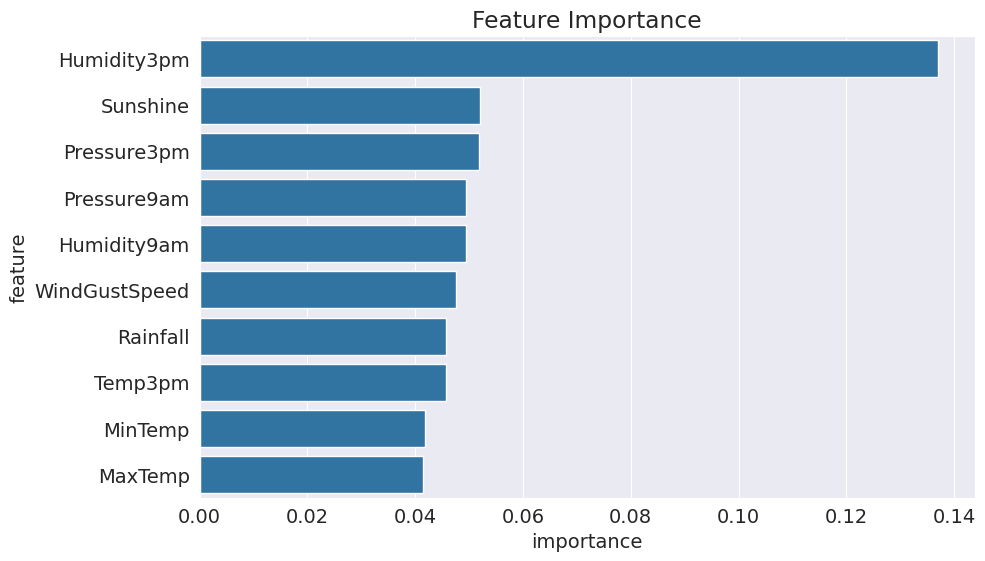

In [66]:
#important features
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [67]:
#hypertuning for randomforest
#base training and val accuracy
rain_prediction=model.predict(X_train)
training_accuracy_score=model.score(X_train,train_target)
val_prediction=model.predict(X_val)
val_accuracy_score=model.score(X_val,val_target)
print(training_accuracy_score,val_accuracy_score)




0.9999483733296621 0.8400159926890565


In [74]:
def hypertuning(**params):
  model1=RandomForestClassifier(n_jobs=-1, random_state=42, **params)
  model1.fit(X_train, train_target)
  return(model1.score(X_train,train_target),model1.score(X_val,val_target))



In [77]:
hypertuning(n_estimators=250)

(0.9999827911098874, 0.8431574137537126)

In [78]:
hypertuning(max_leaf_nodes=2**20)

(0.9999311644395494, 0.8410440941283984)

In [80]:
hypertuning(max_leaf_nodes=2**20,n_estimators=250)

(0.9999827911098874, 0.8423577793008911)